In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import os
from glob import glob
from collections import OrderedDict
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
from scipy import stats
import pop_tools 

from statistics import mean
from matplotlib import style
from scipy import stats
import pandas as pd

style.use('default')
import matplotlib.path as mpath

### get bottle data

In [2]:
csv_file = '/glade/work/kristenk/BATS/bats_bottle.csv'
df = pd.read_csv(csv_file)

#### This csv file was preprocessed via `process_primary_production.sh`

#### Comments

filename:bats_bottle.txt
BATS discrete Bottle Data (excluding HPLC pigments) for  October 1988 to December 2021 .
Note all bottle fires are included that do not have any BATS core parameters so as to be
of use for other ancillary measurements.


### Ship information:

 R/V Weatherbird I (cruises 1,2,8,9,10,11,12 and 13)
 R/V Cape Henlopen (cruises 3,4,5,6 and 7)
 R/V Cape Hatteras (cruises 33,52,52a,53,53a,54,54a,55,55a and 56,195,196,196a 208,208a,209)
 R/V Weatherbird II (all other cruises through 207)
 R/V Atlantic Explorer (cruises 210 through 241, and 243 onwards)
 Ship = R/V Oceanus (cruise 242)
 Ship = R/V Endeavor(cruise 331)
 
 
### Variable list

Id     = Sample Id                                                                               
 A unique bottle id which identifies cruise, cast and bottle number
 9 digit number 
 ```
 !####$$@@, where
 !   = Cruise type, 1=BATS core, 2=BATS bloom a, and 3=BATS bloom b, ect.
 #### = Cruise number
 $$  = Cast Number, 1-80=CTD casts, 81-99=Hydrocasts (i.e. 83=Hydrocast number 3)
 @@  = Bottle number
 e.g., 100488108 is BATS core 48, Hydrocast 1, Bottle 8
 ```
yyyymmdd = Year Month Day   
decy   = Decimal Year     
time   = Time (hhmm)      
latN   = Latitude (Deg N) 
lonW   = Longitude (Deg W)
Depth  = Depth (m)                  
Temp   = Temperature ITS-90 (C)    
CTD_S  = CTD Salinity (PSS-78)      
Sal1   = Salinity-1 (PSS-78)        
Sig-th = Sigma-Theta (kg/m^3)       
O2(1)  = Oxygen-1 (umol/kg)          
OxFixT = Oxygen Fix Temp (C)        
Anom1  = Oxy Anomaly-1 (umol/kg)    
CO2    = dissolved inorganic carbon (umol/kg)              
Alk    = Alkalinity (uequiv)        
NO31   = Nitrate+Nitrite-1 (umol/kg)
NO21   = Nitrite-1 (umol/kg)        
PO41   = Phosphate-1 (umol/kg)      
Si1    = Silicate-1 (umol/kg)       
POC    = POC (ug/kg)                
PON    = PON (ug/kg)                
TOC    = TOC (umol/kg)                
TN     = TN (umol/kg)  
Bact   = Bacteria enumeration (cells*10^8/kg)   
POP    = POP (umol/kg)
TDP    = Total dissolved Phosphorus (nmol/kg)
SRP    = Low-level phosphorus (nmol/kg)
BSi    = Particulate biogenic silica (umol/kg)
LSi    = Particulate lithogenic silica  (umol/kg)
Pro    = Prochlorococcus (cells/ml)
Syn    = Synechococcus (cells/ml)
Piceu  = Picoeukaryotes (cells/ml)
Naneu  = Nanoeukaryotes (cells/ml)

In [3]:
df

,Id,yyyymmdd,decy,time,latN,lonW,Depth,Temp,CTD_S,Sal1,...,Bact,POP,TDP,SRP,BSi,LSi,Pro,Syn,Piceu,Naneu
0,1000100112,19881020,1988.80257,2230,31.783,64.116,2000.5,3.817,-999.000,34.993,...,-999.0,-999.0,-999,-999,-999.0,-999.0,-999,-999,-999,-999
1,1000100111,19881020,1988.80257,2230,31.783,64.116,2200.3,3.577,-999.000,34.982,...,-999.0,-999.0,-999,-999,-999.0,-999.0,-999,-999,-999,-999
2,1000100110,19881020,1988.80257,2230,31.783,64.116,2398.9,3.317,-999.000,-999.000,...,-999.0,-999.0,-999,-999,-999.0,-999.0,-999,-999,-999,-999
3,1000100109,19881020,1988.80257,2230,31.783,64.116,2600.0,3.127,-999.000,34.957,...,-999.0,-999.0,-999,-999,-999.0,-999.0,-999,-999,-999,-999
4,1000100108,19881020,1988.80257,2230,31.783,64.116,2801.7,2.927,-999.000,34.944,...,-999.0,-999.0,-999,-999,-999.0,-999.0,-999,-999,-999,-999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64776,1038802720,20211216,2021.95626,49,32.157,64.017,298.8,18.806,36.628,-999.000,...,-999.0,-999.0,-999,-999,-999.0,-999.0,-999,-999,-999,-999
64777,1038802721,20211216,2021.95626,49,32.157,64.017,401.0,18.000,36.492,-999.000,...,-999.0,-999.0,-999,-999,-999.0,-999.0,-999,-999,-999,-999
64778,1038802722,20211216,2021.95626,49,32.157,64.017,400.1,18.007,36.493,-999.000,...,-999.0,-999.0,-999,-999,-999.0,-999.0,-999,-999,-999,-999
64779,1038802723,20211216,2021.95626,49,32.157,64.017,501.4,16.578,36.246,-999.000,...,-999.0,-999.0,-999,-999,-999.0,-999.0,-999,-999,-999,-999


In [4]:
df['date'] = pd.to_datetime(df['yyyymmdd'], format='%Y%m%d')
df['year']= df['date'].dt.year
df['month']= df['date'].dt.month
df['day']= df['date'].dt.day

In [5]:
df

,Id,yyyymmdd,decy,time,latN,lonW,Depth,Temp,CTD_S,Sal1,...,BSi,LSi,Pro,Syn,Piceu,Naneu,date,year,month,day
0,1000100112,19881020,1988.80257,2230,31.783,64.116,2000.5,3.817,-999.000,34.993,...,-999.0,-999.0,-999,-999,-999,-999,1988-10-20,1988,10,20
1,1000100111,19881020,1988.80257,2230,31.783,64.116,2200.3,3.577,-999.000,34.982,...,-999.0,-999.0,-999,-999,-999,-999,1988-10-20,1988,10,20
2,1000100110,19881020,1988.80257,2230,31.783,64.116,2398.9,3.317,-999.000,-999.000,...,-999.0,-999.0,-999,-999,-999,-999,1988-10-20,1988,10,20
3,1000100109,19881020,1988.80257,2230,31.783,64.116,2600.0,3.127,-999.000,34.957,...,-999.0,-999.0,-999,-999,-999,-999,1988-10-20,1988,10,20
4,1000100108,19881020,1988.80257,2230,31.783,64.116,2801.7,2.927,-999.000,34.944,...,-999.0,-999.0,-999,-999,-999,-999,1988-10-20,1988,10,20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64776,1038802720,20211216,2021.95626,49,32.157,64.017,298.8,18.806,36.628,-999.000,...,-999.0,-999.0,-999,-999,-999,-999,2021-12-16,2021,12,16
64777,1038802721,20211216,2021.95626,49,32.157,64.017,401.0,18.000,36.492,-999.000,...,-999.0,-999.0,-999,-999,-999,-999,2021-12-16,2021,12,16
64778,1038802722,20211216,2021.95626,49,32.157,64.017,400.1,18.007,36.493,-999.000,...,-999.0,-999.0,-999,-999,-999,-999,2021-12-16,2021,12,16
64779,1038802723,20211216,2021.95626,49,32.157,64.017,501.4,16.578,36.246,-999.000,...,-999.0,-999.0,-999,-999,-999,-999,2021-12-16,2021,12,16


### turn all -999 to nans

In [6]:
df = df.replace(-999.,np.nan)

In [7]:
df.OxFix

0         NaN
1         NaN
2         NaN
3         NaN
4         NaN
         ... 
64776    18.8
64777    18.1
64778    18.1
64779    16.8
64780    16.8
Name: OxFix, Length: 64781, dtype: float64

### Make a mean of CTD_S and Sal1

In [8]:
df['Salt'] = df[['CTD_S','Sal1']].mean(axis=1)

In [9]:
df = df.drop(columns=['CTD_S','Sal1'])

In [10]:
df

,Id,yyyymmdd,decy,time,latN,lonW,Depth,Temp,Sig-th,O2,...,LSi,Pro,Syn,Piceu,Naneu,date,year,month,day,Salt
0,1000100112,19881020,1988.80257,2230,31.783,64.116,2000.5,3.817,27.817,255.5,...,NaN,NaN,NaN,NaN,NaN,1988-10-20,1988,10,20,34.993
1,1000100111,19881020,1988.80257,2230,31.783,64.116,2200.3,3.577,27.833,256.8,...,NaN,NaN,NaN,NaN,NaN,1988-10-20,1988,10,20,34.982
2,1000100110,19881020,1988.80257,2230,31.783,64.116,2398.9,3.317,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1988-10-20,1988,10,20,NaN
3,1000100109,19881020,1988.80257,2230,31.783,64.116,2600.0,3.127,27.859,259.4,...,NaN,NaN,NaN,NaN,NaN,1988-10-20,1988,10,20,34.957
4,1000100108,19881020,1988.80257,2230,31.783,64.116,2801.7,2.927,27.868,261.0,...,NaN,NaN,NaN,NaN,NaN,1988-10-20,1988,10,20,34.944
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64776,1038802720,20211216,2021.95626,49,32.157,64.017,298.8,18.806,26.334,NaN,...,NaN,NaN,NaN,NaN,NaN,2021-12-16,2021,12,16,36.628
64777,1038802721,20211216,2021.95626,49,32.157,64.017,401.0,18.000,26.437,NaN,...,NaN,NaN,NaN,NaN,NaN,2021-12-16,2021,12,16,36.492
64778,1038802722,20211216,2021.95626,49,32.157,64.017,400.1,18.007,26.436,NaN,...,NaN,NaN,NaN,NaN,NaN,2021-12-16,2021,12,16,36.493
64779,1038802723,20211216,2021.95626,49,32.157,64.017,501.4,16.578,26.595,NaN,...,NaN,NaN,NaN,NaN,NaN,2021-12-16,2021,12,16,36.246


### Drop columns that I won't use

In [11]:
df = df.drop(columns=['OxFix','Anom1','TN','Bact','LSi'])

In [12]:
df.columns

Index(['Id', 'yyyymmdd', 'decy', 'time', 'latN', 'lonW', 'Depth', 'Temp',
       'Sig-th', 'O2', 'CO2', 'Alk', 'NO31', 'NO21', 'PO41', 'Si1', 'POC',
       'PON', 'TOC', 'POP', 'TDP', 'SRP', 'BSi', 'Pro', 'Syn', 'Piceu',
       'Naneu', 'date', 'year', 'month', 'day', 'Salt'],
      dtype='object')

In [13]:
dates = df.date.unique()

In [14]:
len(dates)

1632

In [15]:
df['Depth'][:30]

0     2000.5
1     2200.3
2     2398.9
3     2600.0
4     2801.7
5     3000.9
6     3200.6
7     3400.3
8     3600.4
9     3803.5
10    4001.5
11    4202.4
12       1.0
13      10.0
14      25.0
15      50.0
16     100.0
17     150.0
18     200.0
19     225.0
20     250.0
21     300.0
22     400.0
23     500.0
24       3.9
25      10.9
26      25.8
27      51.8
28      99.7
29     153.4
Name: Depth, dtype: float64

In [16]:
#df['month'] = df['month'].astype('float64')

In [17]:
selection = df[(df['Depth'] >= 0) & (df['Depth'] < 10)]
selection = selection[(df['month'] == 1)]
selection['Temp'].mean()

20.978913043478276

In [18]:
## 10 depth bins
d1s = [0,10,25,50,100,150,200,250,300,400]
d2s = [10,25,50,100,150,200,250,300,400,500]

In [19]:
df.columns

Index(['Id', 'yyyymmdd', 'decy', 'time', 'latN', 'lonW', 'Depth', 'Temp',
       'Sig-th', 'O2', 'CO2', 'Alk', 'NO31', 'NO21', 'PO41', 'Si1', 'POC',
       'PON', 'TOC', 'POP', 'TDP', 'SRP', 'BSi', 'Pro', 'Syn', 'Piceu',
       'Naneu', 'date', 'year', 'month', 'day', 'Salt'],
      dtype='object')

In [20]:
column_names = ["month","Depth","Temp","Temp_sd","Salt","Salt_sd","O2","NO3","sigma"]

Monthly_clim_df = pd.DataFrame(columns = column_names)

for month in np.arange(1,13,1):
    
    for d in np.arange(0,10,1):

        selection = df[(df['Depth'] >= d1s[d]) & (df['Depth'] <d2s[d])]
        selection = selection[(df['month'] == month)]

        if (len(selection)==0):
            print('missing ', month, ' & depth ', d)

        else:
            
            sigma= selection['Sig-th'].mean()

            temp = selection['Temp'].mean()
            sd_temp = selection['Temp'].std()
            
            salt = selection['Salt'].mean()
            sd_salt = selection['Salt'].std()

            o2 = selection['O2'].mean()
            no3 = selection['NO31'].mean()
            
            Monthly_clim_df = Monthly_clim_df.append({'month' : month, 'Depth' : (d1s[d] + d2s[d])/2,
                                                      'Temp' : temp, 'Temp_sd' : sd_temp,
                                                      'Salt' : salt, 'Salt_sd' : sd_salt,
                                                      'NO3' : no3,
                                                      'O2' : o2,
                                                      'sigma' : sigma},  ignore_index = True)

Monthly_clim_df

,month,Depth,Temp,Temp_sd,Salt,Salt_sd,O2,NO3,sigma
0,1.0,5.0,20.978913,0.672296,36.649524,0.153347,219.028947,0.078298,25.758795
1,1.0,17.5,20.817266,0.574667,36.636414,0.097080,219.623214,0.085741,25.792463
2,1.0,37.5,20.790569,0.606430,36.663735,0.089600,219.033333,0.225349,25.820911
3,1.0,75.0,20.712174,0.559625,36.656745,0.098271,218.844828,0.104940,25.839766
4,1.0,125.0,20.218456,0.698589,36.648362,0.094072,213.083871,0.620957,25.969231
...,...,...,...,...,...,...,...,...,...
115,12.0,175.0,19.281135,0.545825,36.626950,0.047803,199.324590,2.328182,26.200050
116,12.0,225.0,18.845109,0.439727,36.607577,0.048208,200.935484,2.948214,26.300301
117,12.0,275.0,18.550986,0.488319,36.581546,0.065438,195.915789,3.653250,26.357700
118,12.0,350.0,18.296370,0.488375,36.556076,0.065707,200.289362,4.234186,26.405234


In [21]:
month = 12

selection = Monthly_clim_df[(Monthly_clim_df['month'] == month)]

#print(selection['Depth'].iloc[0],selection['sigma'].iloc[0])

surf_val = selection['sigma'].iloc[0]

selection['sigma_diff_surf'] = selection['sigma'] - surf_val

In [22]:
selection

,month,Depth,Temp,Temp_sd,Salt,Salt_sd,O2,NO3,sigma,sigma_diff_surf
110,12.0,5.0,22.647688,0.560534,36.613126,0.112806,212.818367,0.009344,25.260765,0.000000
111,12.0,17.5,22.628763,0.611842,36.612794,0.106698,213.260345,0.008136,25.264608,0.003843
112,12.0,37.5,22.649267,0.525770,36.605188,0.107632,212.879592,0.006458,25.255225,-0.005540
113,12.0,75.0,22.208031,0.850531,36.616430,0.098313,213.016923,0.115968,25.390089,0.129324
114,12.0,125.0,20.439921,1.082473,36.652729,0.065042,206.448182,0.897264,25.906730,0.645965
115,12.0,175.0,19.281135,0.545825,36.626950,0.047803,199.324590,2.328182,26.200050,0.939285
116,12.0,225.0,18.845109,0.439727,36.607577,0.048208,200.935484,2.948214,26.300301,1.039535
117,12.0,275.0,18.550986,0.488319,36.581546,0.065438,195.915789,3.653250,26.357700,1.096935
118,12.0,350.0,18.296370,0.488375,36.556076,0.065707,200.289362,4.234186,26.405234,1.144469
119,12.0,450.0,17.457600,0.923920,36.425204,0.158821,192.730952,6.334054,26.514617,1.253851


#### I hand calculated the linear interpolation between the two depths for sigma difference from surf

Jan MLD = 92.3 m

Feb MLD = 144.44 m

Mar MLD = 129.17 m

Apr MLD = 37.5 m

May MLD = 8.6 m

Jun MLD = 7.5 m

Jul MLD = 6.6 m

Aug MLD = 8.6 m

Sep MLD = 17.5 m

Oct MLD = 30.7m

Nov MLD = 48.3 m

Dec MLD = 73.8 m

In [23]:
xlabels = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
xvals = np.arange(1,13,1)

In [24]:
colors = ['lightcoral','red','darkorange','gold','lightgreen','green','darkturquoise','dodgerblue','blue','darkviolet','magenta','hotpink']

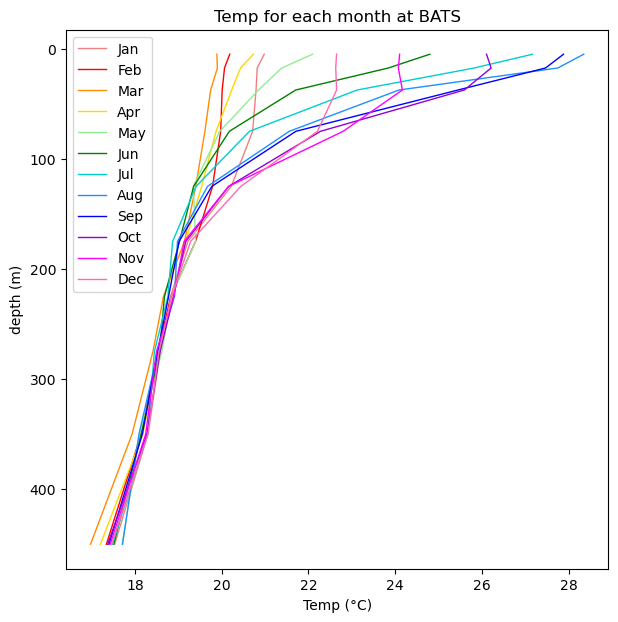

In [25]:
fig = plt.figure(figsize=(7,7))

ax = fig.add_subplot(1,1,1)
ax.set_title('Temp for each month at BATS')

for month in np.arange(0,12,1):
    selection = Monthly_clim_df[(Monthly_clim_df['month']==month+1)]
    ax.plot(selection.Temp, selection['Depth'], label=xlabels[month], linewidth=1, color = colors[month])
ax.legend()
ax.set(ylabel='depth (m)',xlabel='Temp (°C)')
plt.gca().invert_yaxis()


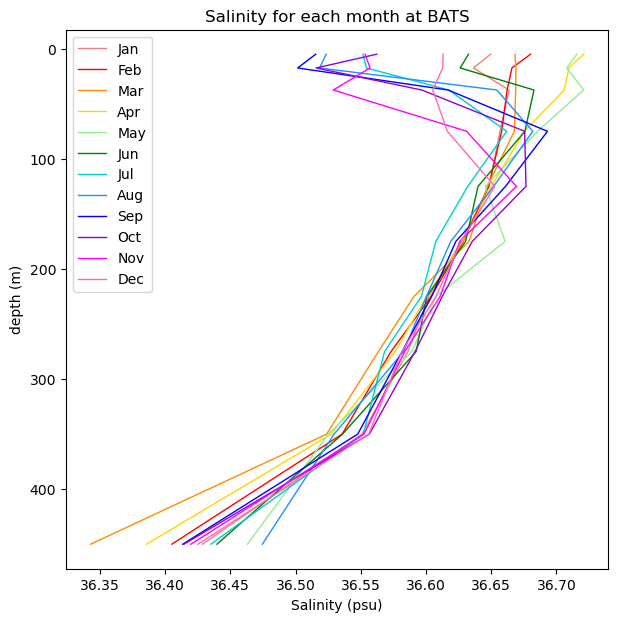

In [26]:
fig = plt.figure(figsize=(7,7))

ax = fig.add_subplot(1,1,1)
ax.set_title('Salinity for each month at BATS')

for month in np.arange(0,12,1):
    selection = Monthly_clim_df[(Monthly_clim_df['month']==month+1)]
    ax.plot(selection.Salt, selection['Depth'], label=xlabels[month], linewidth=1, color = colors[month])
ax.legend()
ax.set(ylabel='depth (m)',xlabel='Salinity (psu)')
plt.gca().invert_yaxis()


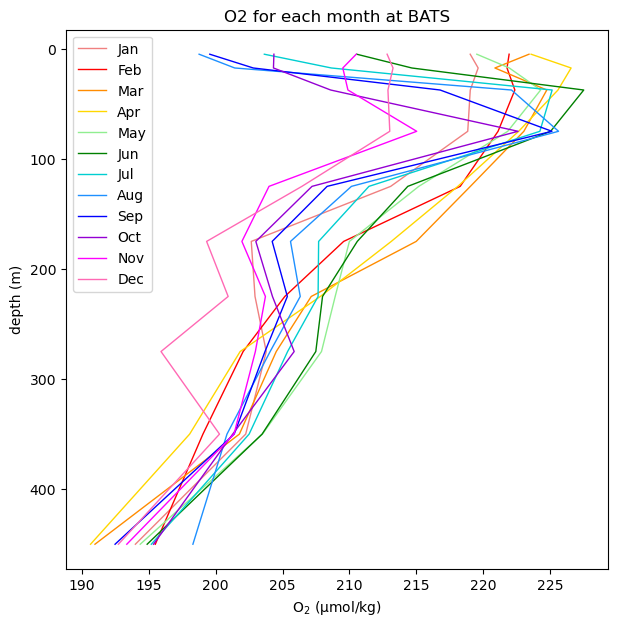

In [27]:
fig = plt.figure(figsize=(7,7))

ax = fig.add_subplot(1,1,1)
ax.set_title('O2 for each month at BATS')

for month in np.arange(0,12,1):
    selection = Monthly_clim_df[(Monthly_clim_df['month']==month+1)]
    ax.plot(selection.O2, selection['Depth'], label=xlabels[month], linewidth=1, color = colors[month])
ax.legend()
ax.set(ylabel='depth (m)',xlabel='O$_2$ (µmol/kg)')
plt.gca().invert_yaxis()


In [28]:
Monthly_clim_df

,month,Depth,Temp,Temp_sd,Salt,Salt_sd,O2,NO3,sigma
0,1.0,5.0,20.978913,0.672296,36.649524,0.153347,219.028947,0.078298,25.758795
1,1.0,17.5,20.817266,0.574667,36.636414,0.097080,219.623214,0.085741,25.792463
2,1.0,37.5,20.790569,0.606430,36.663735,0.089600,219.033333,0.225349,25.820911
3,1.0,75.0,20.712174,0.559625,36.656745,0.098271,218.844828,0.104940,25.839766
4,1.0,125.0,20.218456,0.698589,36.648362,0.094072,213.083871,0.620957,25.969231
...,...,...,...,...,...,...,...,...,...
115,12.0,175.0,19.281135,0.545825,36.626950,0.047803,199.324590,2.328182,26.200050
116,12.0,225.0,18.845109,0.439727,36.607577,0.048208,200.935484,2.948214,26.300301
117,12.0,275.0,18.550986,0.488319,36.581546,0.065438,195.915789,3.653250,26.357700
118,12.0,350.0,18.296370,0.488375,36.556076,0.065707,200.289362,4.234186,26.405234


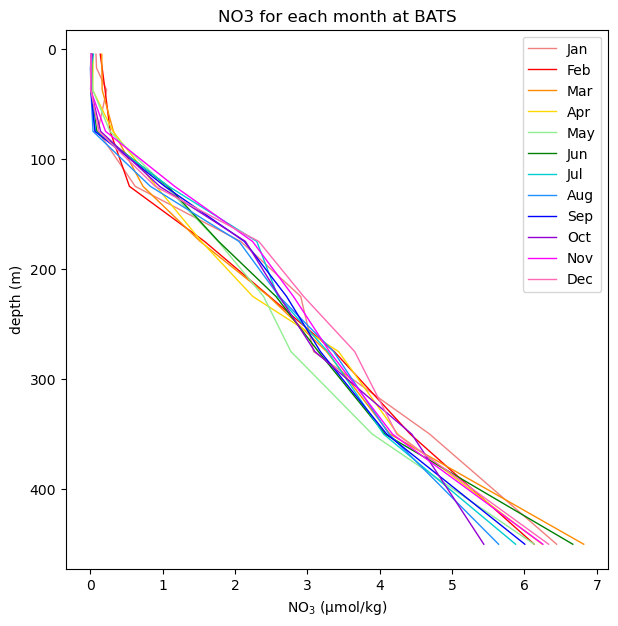

In [29]:
fig = plt.figure(figsize=(7,7))

ax = fig.add_subplot(1,1,1)
ax.set_title('NO3 for each month at BATS')

for month in np.arange(0,12,1):
    selection = Monthly_clim_df[(Monthly_clim_df['month']==month+1)]
    ax.plot(selection.NO3, selection['Depth'], label=xlabels[month], linewidth=1, color = colors[month])
ax.legend()
ax.set(ylabel='depth (m)',xlabel='NO$_3$ (µmol/kg)')
plt.gca().invert_yaxis()


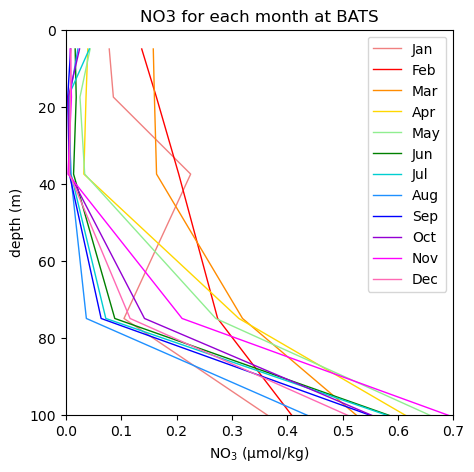

In [30]:
fig = plt.figure(figsize=(5,5))

ax = fig.add_subplot(1,1,1)
ax.set_title('NO3 for each month at BATS')

for month in np.arange(0,12,1):
    selection = Monthly_clim_df[(Monthly_clim_df['month']==month+1)]
    ax.plot(selection.NO3, selection['Depth'], label=xlabels[month], linewidth=1, color = colors[month])
ax.legend()
ax.set(ylabel='depth (m)',xlabel='NO$_3$ (µmol/kg)')
ax.set_ylim(0,100)
ax.set_xlim(0,0.7)
plt.gca().invert_yaxis()


### Grab a CESM simulation

In [31]:
import utils

In [32]:
ds_grid = pop_tools.get_grid('POP_gx1v7').isel(nlon=slice(280,320),nlat=slice(250,350))
lats = ds_grid.TLAT
lons = ds_grid.TLONG
area = ds_grid.TAREA
lons_norm = utils.normal_lons(lons)

In [33]:
case = 'g.e22.GOMIPECOIAF_JRA-1p4-2018.TL319_g17.4p2z.002branch'
path = '/glade/campaign/cesm/development/bgcwg/projects/CESM2-OMIP2-like-4p2z-run/'+case+'/ocn/proc/tseries/month_1/'
#path = '/glade/scratch/kristenk/archive/' + case + '/ocn/proc/tseries/month_1/'

In [34]:
variables = ['NO3','TEMP','O2','HMXL']

In [35]:
def preprocess(ds):
    ds["time"] = ds.time_bound.compute().mean(dim="d2")
    ds=ds.isel(z_t=slice(0,34))
    ds=ds.isel(time=slice(384,768),nlon=slice(280,320),nlat=slice(250,350))
    return ds

In [36]:
ds_fosi = xr.Dataset()

for var in variables:
    
    print('starting on ', var)
    ################ FOSI
    
    #ds_tmp = xr.open_dataset(path+case+'.pop.h.'+var+'.??????-??????.nc')
    #ds_tmp['time'] = time
    
    files = sorted(glob(f'{path}/{case}.pop.h.{var}.??????-??????.nc'))       
    ds_tmp = xr.open_mfdataset(files, data_vars="minimal", coords='minimal', compat="override", parallel=True, concat_dim="time",
                       drop_variables=["transport_components", "transport_regions"], decode_times=True,combine='nested',preprocess=preprocess)

    keep_vars=['z_t','z_t_150m','time_bound','dz','TLAT','TLONG','time','KMT'] + [var]

    ds_tmp = ds_tmp.drop([v for v in ds_tmp.variables if v not in keep_vars]) #.compute()
        
    ds_fosi = xr.merge([ds_fosi,ds_tmp])

starting on  NO3
starting on  TEMP
starting on  O2
starting on  HMXL


In [37]:
#ds_fosi.O2.isel(time=0,z_t=0,nlon=slice(280,320),nlat=slice(250,350)).plot()

In [38]:
def get_ClusterClient():
    import dask
    from dask_jobqueue import PBSCluster
    from dask.distributed import Client
    cluster = PBSCluster(
        cores=2,
        memory='20 GB',
        processes=1,
        queue='casper',
        resource_spec='select=1:ncpus=1:mem=20GB',
        project='NCGD0011',
        walltime='01:00:00',
        interface='ext',)

    dask.config.set({
        'distributed.dashboard.link':
        'https://jupyterhub.hpc.ucar.edu/stable/user/{USER}/proxy/{port}/status'
    })
    client = Client(cluster)
    return cluster, client

In [39]:
cluster, client = get_ClusterClient()
cluster.scale(6) 
client

Client Scheduler: tcp://128.117.208.75:41683 Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/kristenk/proxy/8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


In [40]:
box1_latmin = 30.5
box1_latmax = 32.5
box1_lonmin = -65.5
box1_lonmax = -63.5

In [41]:
ds_fosi

<xarray.Dataset>
Dimensions:     (d2: 2, nlat: 100, nlon: 40, time: 384, z_t: 34, z_t_150m: 15)
Coordinates:
    TLAT        (nlat, nlon) float64 dask.array<chunksize=(100, 40), meta=np.ndarray>
    TLONG       (nlat, nlon) float64 dask.array<chunksize=(100, 40), meta=np.ndarray>
  * time        (time) object 1990-01-16 12:00:00 ... 2021-12-16 12:00:00
  * z_t         (z_t) float32 500.0 1.5e+03 2.5e+03 ... 4.827e+04 5.277e+04
  * z_t_150m    (z_t_150m) float32 500.0 1.5e+03 2.5e+03 ... 1.35e+04 1.45e+04
Dimensions without coordinates: d2, nlat, nlon
Data variables:
    KMT         (nlat, nlon) float64 dask.array<chunksize=(100, 40), meta=np.ndarray>
    NO3         (time, z_t, nlat, nlon) float32 dask.array<chunksize=(384, 34, 100, 40), meta=np.ndarray>
    dz          (z_t) float32 dask.array<chunksize=(34,), meta=np.ndarray>
    time_bound  (time, d2) object dask.array<chunksize=(384, 2), meta=np.ndarray>
    TEMP        (time, z_t, nlat, nlon) float32 dask.array<chunksize=(384, 34, 100, 40), meta=np.ndarray>
    O2          (time, z_t, nlat, nlon) float32 dask.array<chunksize=(384, 34, 100, 40), meta=np.ndarray>
    HMXL        (time, nlat, nlon) float32 dask.array<chunksize=(384, 100, 40), meta=np.ndarray>

In [42]:
ones = np.full((100,40),1,dtype=int)
ones = xr.DataArray(ones,dims=('nlat','nlon'))
ones = ones.where(ds_grid.REGION_MASK>0)

In [43]:
ds_fosi = ds_fosi.where(lats<box1_latmax).where(lats>box1_latmin).where(lons_norm<box1_lonmax).where(lons_norm>box1_lonmin)

In [44]:
# lons_norm = utils.normal_lons(lons)

# clim_box1 = xr.Dataset({v: ds_clim_fosi[v] for v in ['month']})

# for var in variables:
#     print(var)
    
#     mask = ones.where(lats<box1_latmax).where(lats>box1_latmin).where(lons_norm<box1_lonmax).where(lons_norm>box1_lonmin)
#     masked_area = area.where(mask==1)
#     masked_fosi = ds_clim_fosi[var].where(mask==1)
    
#     clim_box1[var] = (masked_fosi * masked_area).sum(dim=('nlon','nlat')) / masked_area.sum(dim=('nlon','nlat'))

In [45]:
lons_norm = utils.normal_lons(lons)

ts_box1 = xr.Dataset({v: ds_fosi[v] for v in ['time']})

for var in variables:
    print(var)
    
    mask = ones.where(lats<box1_latmax).where(lats>box1_latmin).where(lons_norm<box1_lonmax).where(lons_norm>box1_lonmin)
    masked_area = area.where(mask==1)
    masked_fosi = ds_fosi[var].where(mask==1)
    
    ts_box1[var] = (masked_fosi * masked_area).sum(dim=('nlon','nlat')) / masked_area.sum(dim=('nlon','nlat'))

NO3
TEMP
O2
HMXL


In [46]:
ts_box1 = ts_box1.compute()

In [47]:
# ds_clim_fosi = ds_fosi.groupby('time.month').mean('time').compute()

In [48]:
clim_box1 = ts_box1.groupby('time.month').mean('time').compute()

In [49]:
clim_box1

<xarray.Dataset>
Dimensions:  (month: 12, z_t: 34)
Coordinates:
  * z_t      (z_t) float32 500.0 1.5e+03 2.5e+03 ... 4.827e+04 5.277e+04
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    NO3      (month, z_t) float64 1.782 1.784 1.79 1.798 ... 18.63 19.5 20.25
    TEMP     (month, z_t) float64 21.06 21.05 21.05 21.05 ... 14.44 13.74 12.99
    O2       (month, z_t) float64 221.1 221.0 220.9 220.8 ... 112.9 112.0 113.0
    HMXL     (month) float64 1.186e+04 1.341e+04 ... 6.608e+03 8.997e+03

In [50]:
colors[1]

'red'

In [51]:
colors[6]

'darkturquoise'

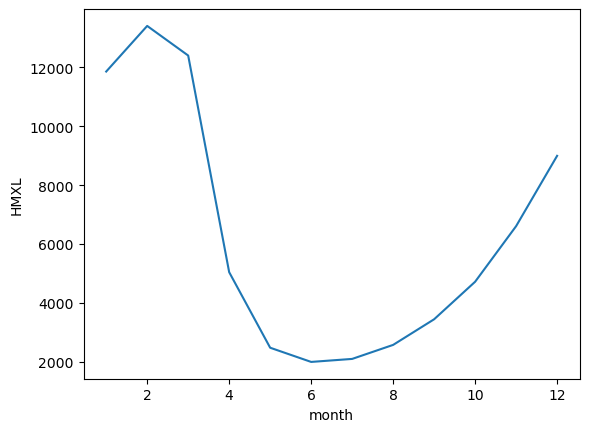

In [52]:
clim_box1.HMXL.plot()

In [53]:
clim_box1.HMXL[1].values*0.01

134.1059722952577

In [54]:
clim_box1.HMXL[5]*0.01

<xarray.DataArray 'HMXL' ()>
array(19.95343027)
Coordinates:
    month    int64 6

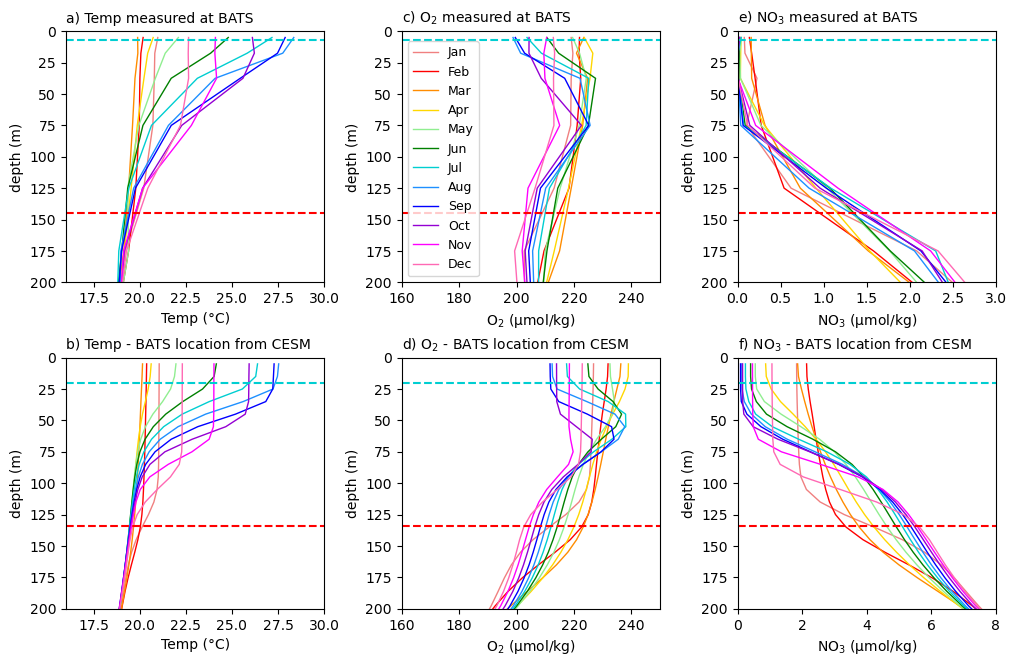

In [61]:
fig = plt.figure(figsize=(12,7.5))

################## TEMP - Bats
ax = fig.add_subplot(2,3,1)
ax.set_title('a) Temp measured at BATS',fontsize=10,loc='left')
for month in np.arange(0,12,1):
    selection = Monthly_clim_df[(Monthly_clim_df['month']==month+1)]
    ax.plot(selection.Temp, selection['Depth'], label=xlabels[month], linewidth=1, color = colors[month])
#ax.legend()
ax.axhline(144.44, linestyle='--', color='red')
ax.axhline(6.6, linestyle='--', color='darkturquoise')
ax.set(ylabel='depth (m)',xlabel='Temp (°C)')
ax.set_ylim(0,200)
ax.set_xlim(16,30)
plt.gca().invert_yaxis()

################# O2 - Bats

ax = fig.add_subplot(2,3,2)
ax.set_title('c) O$_2$ measured at BATS',fontsize=10,loc='left')

for month in np.arange(0,12,1):
    selection = Monthly_clim_df[(Monthly_clim_df['month']==month+1)]
    ax.plot(selection.O2, selection['Depth'], label=xlabels[month], linewidth=1, color = colors[month])
ax.legend(fontsize=9)
ax.axhline(144.44, linestyle='--', color='red')
ax.axhline(6.6, linestyle='--', color='darkturquoise')
ax.set(ylabel='depth (m)',xlabel='O$_2$ (µmol/kg)')
ax.set_ylim(0,200)
ax.set_xlim(160,250)
plt.gca().invert_yaxis()

################ NO3 at BATS

ax = fig.add_subplot(2,3,3)
ax.set_title('e) NO$_3$ measured at BATS',fontsize=10,loc='left')

for month in np.arange(0,12,1):
    selection = Monthly_clim_df[(Monthly_clim_df['month']==month+1)]
    ax.plot(selection.NO3, selection['Depth'], label=xlabels[month], linewidth=1, color = colors[month])
#ax.legend()
ax.axhline(144.44, linestyle='--', color='red')
ax.axhline(6.6, linestyle='--', color='darkturquoise')
ax.set(ylabel='depth (m)',xlabel='NO$_3$ (µmol/kg)')
ax.set_ylim(0,200)
ax.set_xlim(0,3)
plt.gca().invert_yaxis()

######## TEMP CESM

ax = fig.add_subplot(2,3,4)
ax.set_title('b) Temp - BATS location from CESM',fontsize=10,loc='left')

for month in np.arange(0,12,1):
    ax.plot(clim_box1.TEMP.isel(month=month), clim_box1['z_t']*0.01, label=xlabels[month], linewidth=1, color = colors[month])
#ax.legend()
ax.axhline(clim_box1.HMXL[1].values*0.01, linestyle='--', color='red')
ax.axhline(clim_box1.HMXL[5].values*0.01, linestyle='--', color='darkturquoise')
ax.set(ylabel='depth (m)',xlabel='Temp (°C)')
ax.set_ylim(0,200)
ax.set_xlim(16,30)
plt.gca().invert_yaxis()

######### O2 CESM

ax = fig.add_subplot(2,3,5)
ax.set_title('d) O$_2$ - BATS location from CESM',fontsize=10,loc='left')

for month in np.arange(0,12,1):
    ax.plot(clim_box1.O2.isel(month=month)*1.026, clim_box1['z_t']*0.01, label=xlabels[month], linewidth=1, color = colors[month])
#ax.legend()
ax.axhline(clim_box1.HMXL[1].values*0.01, linestyle='--', color='red')
ax.axhline(clim_box1.HMXL[5].values*0.01, linestyle='--', color='darkturquoise')
ax.set(ylabel='depth (m)',xlabel='O$_2$ (µmol/kg)')
ax.set_ylim(0,200)
ax.set_xlim(160,250)
plt.gca().invert_yaxis()


###### NO3 CESM

ax = fig.add_subplot(2,3,6)
ax.set_title('f) NO$_3$ - BATS location from CESM',fontsize=10,loc='left')

for month in np.arange(0,12,1):
    ax.plot(clim_box1.NO3.isel(month=month)*1.026, clim_box1['z_t']*0.01, label=xlabels[month], linewidth=1, color = colors[month])
#ax.legend()
ax.axhline(clim_box1.HMXL[1].values*0.01, linestyle='--', color='red')
ax.axhline(clim_box1.HMXL[5].values*0.01, linestyle='--', color='darkturquoise')
ax.set(ylabel='depth (m)',xlabel='NO$_3$ (µmol/kg)')
ax.set_ylim(0,200)
ax.set_xlim(0,8)
plt.gca().invert_yaxis()

fig.subplots_adjust(wspace=0.3, hspace=0.3)